In [1]:
import sys
sys.path.append('../src/')
del sys

In [2]:
import math

import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import matplotlib as mpl

import event2vec.models as models
import event2vec.losses as losses
import event2vec.utils as utils

from event2vec.datasets import VBFHDataset
from event2vec.util import tril_to_matrix

import treescope
treescope.basic_interactive_setup()

In [3]:
import dataclasses
from typing import Callable
import optax
from rich.progress import TextColumn
from event2vec.util import standard_pbar

@dataclasses.dataclass
class TrainingConfig:
    """Configuration for the training process."""

    test_fraction: float
    """Fraction of the dataset to use for testing."""
    batch_size: int
    """Batch size for training."""
    learning_rate: float
    """Learning rate for the optimizer."""
    epochs: int
    """Number of epochs to train for."""
    loss_fn: Callable
    """Loss function to use for training."""

def train(
    config: TrainingConfig,
    *,
    model, data, key):
    
    key, subkey = jax.random.split(key)
    data_train, data_test = data.split(config.test_fraction, key=subkey)
    diff_model, static_model = utils.partition_trainable_and_static(model)
    
    @eqx.filter_jit
    def make_step(
        diff_model, batch,
        opt_state: optax.OptState,
        *,
        key: jax.Array):
        
        @eqx.filter_value_and_grad
        def loss_grad(diff_model, batch, *, key):
            model = eqx.combine(diff_model, static_model)
            return config.loss_fn(model, batch, key=key)

        loss, grads = loss_grad(diff_model, batch, key=key)
        updates, opt_state = optim.update(grads, opt_state, diff_model)
        diff_model = eqx.apply_updates(diff_model, updates)
        return loss, diff_model, opt_state

    optim = optax.adamw(config.learning_rate, b1=0.9)
    opt_state = optim.init(diff_model)

    train_loss_history: list[float] = []
    test_loss_history: list[float] = []
    pbar = standard_pbar(TextColumn("Test loss: {task.fields[loss]:.4f}"))
    with pbar as progress:
        epoch_task = progress.add_task("Training...", total=config.epochs, loss=0.0)
        for _ in range(config.epochs):
            tmp = []
            for i, batch in enumerate(data_train.iter_batch(config.batch_size)):
                key, subkey = jax.random.split(key)
                loss, diff_model, opt_state = make_step(
                    diff_model, batch, opt_state, key=subkey
                )
                tmp.append(loss.item())
            train_loss_history.append(sum(tmp) / len(tmp))
            key, subkey = jax.random.split(key)
            model = eqx.combine(diff_model, static_model)
            test_loss = eqx.filter_jit(config.loss_fn)(
                model, data_test, key=subkey
            ).item()
            test_loss_history.append(test_loss)
            progress.update(epoch_task, advance=1, loss=test_loss)

    return model, train_loss_history, test_loss_history

In [4]:
data = VBFHDataset.from_lhe("../data/smeftsim_VBFH-*.lhe.gz")

Output()

LHE weight fit residuals mean: 9.948202201251477e-13 std: 5.530732122283055e-13


/Users/ncsmith/src/sbi4eft/event2vec/src/event2vec/datasets/lhedataset.py:240: UserWarning: Coefficient matrix is not positive semi-definite, negative eigenvalues: [-1.0845202e-05]
  latent_norm = QuadraticFormNormalization.from_coefficients(


In [5]:
input_shape = data.observables.shape[1:]
latent_shape = data.latent_data.shape[1:]

input_dim = math.prod(input_shape)

assert len(latent_shape) == 1
param_dim = int((jnp.sqrt(8 * latent_shape[0] + 1) - 1) / 2)

print(f"{input_shape = }\n{param_dim = }")

input_shape = (13,)
param_dim = 6


In [6]:
model_init_key = jax.random.key(1)
training_key = jax.random.key(2)

D_model_init_key, A_model_init_key = jax.random.split(model_init_key, 2)
D_training_key, A_training_key = jax.random.split(training_key, 2)

In [7]:
latent_matrix = tril_to_matrix(data.latent_data)
avg_latent_matrix = latent_matrix.mean(axis=0)

eigvals, eigvectors = jnp.linalg.eigh(avg_latent_matrix)

In [8]:
U_model = utils.ModelWrapper(jnp.eye(param_dim), is_static=True)

In [9]:
eps = 1e-6

reweights = latent_matrix[..., range(param_dim), range(param_dim)]

log_reweights = jnp.log(jnp.clip(reweights, min=eps))

log_min = jnp.min(log_reweights, axis=0) - jnp.log(1.2)
log_max = jnp.max(log_reweights, axis=0) + jnp.log(1.2)

del reweights, log_reweights

In [10]:
mlp_config = {
    'in_shape': input_shape,
    'out_shape': (param_dim,),
    'hidden_widths': [16, 32, 32, 16],
    'hidden_activation': jax.nn.relu,
    'final_activation': models.activations.ExpAffineLogistic(log_min=log_min, log_max=log_max),
    'use_hidden_bias': True,
    'use_final_bias': True
}

untrained_D_model = models.MLP(**mlp_config, key=D_model_init_key)

In [11]:
mlp_config = {
    'in_shape': input_shape,
    'out_shape': (param_dim, param_dim),
    'hidden_widths': [64, 128, 128, 128, 64],
    'hidden_activation': jax.nn.relu,
    'final_activation': jax.nn.identity,
    'use_hidden_bias': True,
    'use_final_bias': True
}

untrained_A_model = models.MLP(**mlp_config, key=A_model_init_key)

In [12]:
untrained_psd_matrix_model = models.psd_matrix_models.U_sqrtD_At_A_sqrtD_Ut_Model(
    N = param_dim,
    U_model=U_model,
    D_model=untrained_D_model,
    A_model=untrained_A_model,
    normalize_A_cols=True
)

## Training only the D model

In [13]:
untrained_psd_matrix_model = utils.set_is_static_at(
    where=lambda x: x.A_model,
    pytree=untrained_psd_matrix_model,
    is_static_value=True
)

In [14]:
loss = losses.psd_matrix_losses.DiagMSELoss()

In [15]:
training_config = TrainingConfig(
    test_fraction=0.2,
    batch_size=256,
    learning_rate=0.001,
    epochs=200,
    loss_fn=loss
)

In [16]:
intermediate_psd_matrix_model, train_loss_history, test_loss_history = train(config=training_config, model=untrained_psd_matrix_model, data=data, key=D_training_key)

Output()

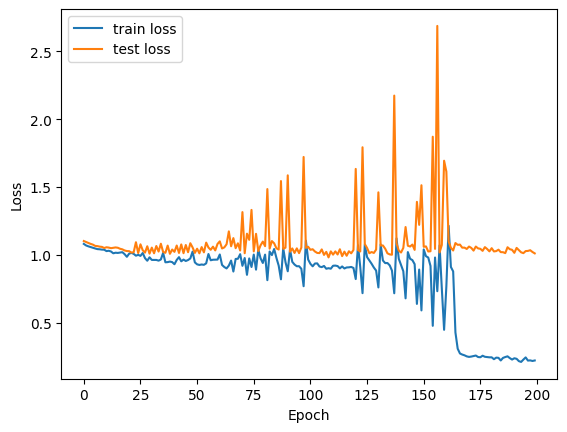

In [17]:
fig, ax = plt.subplots()

ax.plot(train_loss_history, label="train loss")
ax.plot(test_loss_history, label="test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
# ax.set_ylim(0, 4)
# ax.set_yscale('log')
ax.legend()

## Training both A and D models

In [18]:
intermediate_psd_matrix_model = utils.set_is_static_at(
    where=lambda x: x.A_model,
    pytree=intermediate_psd_matrix_model,
    is_static_value=False
)

In [19]:
param_mean = jnp.zeros(param_dim).at[0].set(1)
param_cov = jnp.diag((jnp.array([0, 0.5, 2.0, 0.005, 0.00025, 0.003]) * 10)**2)

loss = losses.psd_matrix_losses.HyperQuadNormLoss(
    P_tensor=utils.mvn_fourth_moment(
        mean=param_mean,
        cov=param_cov,
        is_central=False
    )
)

In [20]:
training_config = TrainingConfig(
    test_fraction=0.2,
    batch_size=128,
    learning_rate=0.001,
    epochs=100,
    loss_fn=loss
)

In [21]:
trained_psd_matrix_model, train_loss_history, test_loss_history = train(config=training_config, model=intermediate_psd_matrix_model, data=data, key=A_training_key)

Output()

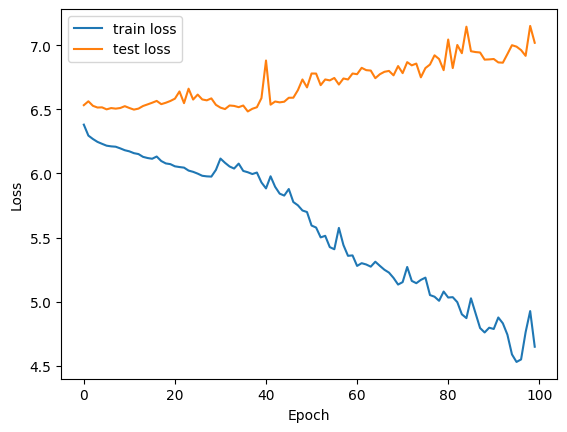

In [22]:
fig, ax = plt.subplots()

ax.plot(train_loss_history, label="train loss")
ax.plot(test_loss_history, label="test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
# ax.set_ylim(0, 4)
ax.legend()

In [23]:
latent_matrix = tril_to_matrix(data.latent_data)

In [24]:
pred_matrix_before_training = jax.vmap(untrained_psd_matrix_model)(data.observables)
pred_matrix = jax.vmap(trained_psd_matrix_model)(data.observables)

In [25]:
latent_lengths = []
pred_lengths = []
pred_lengths_before_training = []

for i in range(6):
    latent_lengths.append(jnp.sum(jnp.sum(latent_matrix * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))
    pred_lengths.append(jnp.sum(jnp.sum(pred_matrix * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))
    pred_lengths_before_training.append(jnp.sum(jnp.sum(pred_matrix_before_training * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))

latent_lengths = jnp.array(latent_lengths)
pred_lengths = jnp.array(pred_lengths)
pred_lengths_before_training = jnp.array(pred_lengths_before_training)

In [26]:
pred_lengths_before_training

Array([[0.00560802, 0.00576144, 0.0051292 , ..., 0.00474459, 0.00558459,
        0.004888  ],
       [0.00401549, 0.00392662, 0.00421719, ..., 0.00399991, 0.0040738 ,
        0.0039974 ],
       [0.00376938, 0.00270002, 0.00241262, ..., 0.00277159, 0.00213255,
        0.00246154],
       [0.01036677, 0.0108338 , 0.0101676 , ..., 0.00913855, 0.00944703,
        0.01044483],
       [0.02287774, 0.01884335, 0.0160858 , ..., 0.02356103, 0.01272949,
        0.01551784],
       [0.9772016 , 0.9811978 , 0.9799078 , ..., 0.96914566, 0.9831697 ,
        0.982178  ]], dtype=float32)

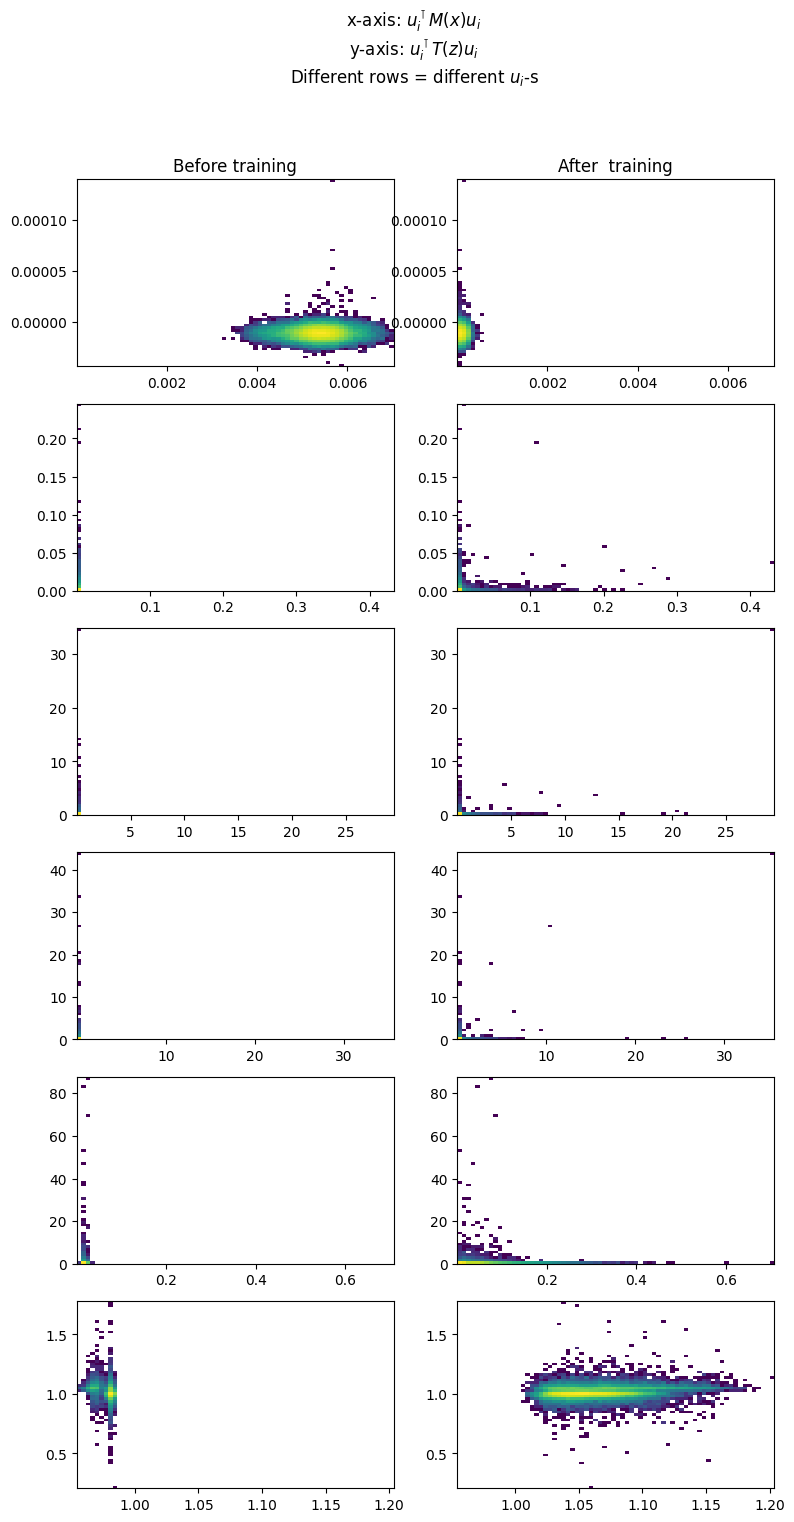

In [27]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(9, 17))

for i in range(6):
    x_lo = min(jnp.min(pred_lengths[i]), jnp.min(pred_lengths_before_training[i]))
    x_hi = max(jnp.max(pred_lengths[i]), jnp.max(pred_lengths_before_training[i]))

    y_lo = jnp.min(latent_lengths[i])
    y_hi = jnp.max(latent_lengths[i])
    
    for ax in axes[i]:
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)

    axes[i][0].hist2d(pred_lengths_before_training[i], latent_lengths[i], range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())
    axes[i][1].hist2d(pred_lengths[i], latent_lengths[i], range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())

axes[0][0].set_title("Before training")
axes[0][1].set_title("After  training")

fig.suptitle("x-axis: $u_i^\\intercal M(x) u_i$ \ny-axis: $u_i^\\intercal T(z) u_i$\nDifferent rows = different $u_i$-s")

None

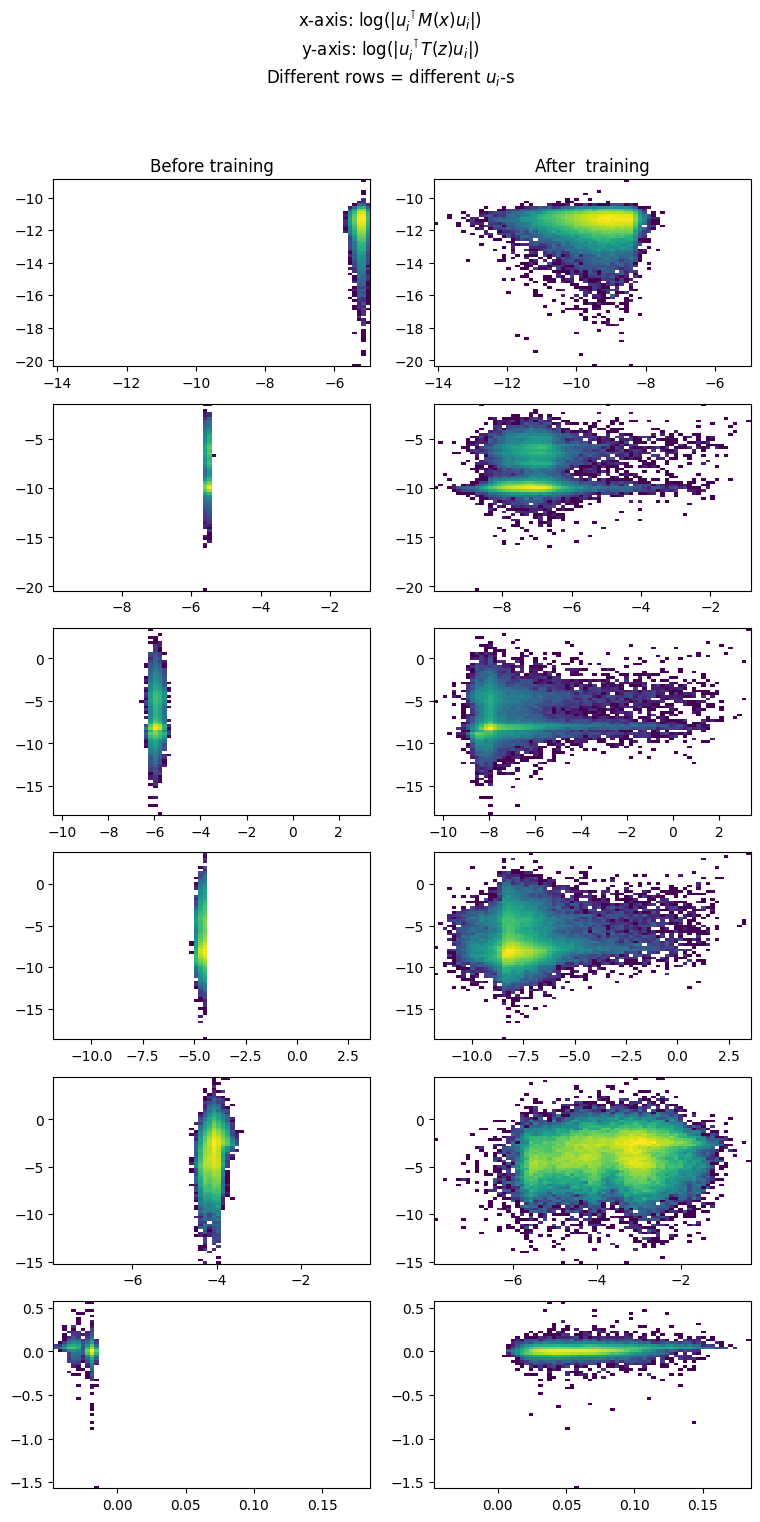

In [28]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(9, 17))

for i in range(6):
    x_lo = min(jnp.min(jnp.log(jnp.abs(pred_lengths[i]))), jnp.min(jnp.log(jnp.abs(pred_lengths_before_training[i]))))
    x_hi = max(jnp.max(jnp.log(jnp.abs(pred_lengths[i]))), jnp.max(jnp.log(jnp.abs(pred_lengths_before_training[i]))))

    y_lo = jnp.min(jnp.log(jnp.abs(latent_lengths[i])))
    y_hi = jnp.max(jnp.log(jnp.abs(latent_lengths[i])))
    
    for ax in axes[i]:
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)

    axes[i][0].hist2d(jnp.log(jnp.abs(pred_lengths_before_training[i])), jnp.log(jnp.abs(latent_lengths[i])), range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())
    axes[i][1].hist2d(jnp.log(jnp.abs(pred_lengths[i])), jnp.log(jnp.abs(latent_lengths[i])), range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())

axes[0][0].set_title("Before training")
axes[0][1].set_title("After  training")

fig.suptitle("x-axis: $\\log(|u_i^\\intercal M(x) u_i|)$ \ny-axis: $\\log(|u_i^\\intercal T(z) u_i|)$\nDifferent rows = different $u_i$-s")

None

In [29]:
avg_pred_matrix_before_training = pred_matrix_before_training.mean(axis=0)
avg_pred_matrix = pred_matrix.mean(axis=0)

In [30]:
jnp.linalg.eigvals(avg_latent_matrix - avg_pred_matrix_before_training)

Array([ 0.17242968+0.j, -0.06188918+0.j,  0.02208043+0.j,  0.01455294+0.j,
        0.00600918+0.j, -0.00308993+0.j], dtype=complex64)

In [31]:
jnp.linalg.eigvals(avg_latent_matrix - avg_pred_matrix)

Array([-0.06090457+0.j,  0.08383842+0.j, -0.01200337+0.j,  0.01499172+0.j,
        0.00013548+0.j,  0.00033   +0.j], dtype=complex64)

In [32]:
alt_param = jnp.ones(param_dim).at[1:].set(
    jax.random.multivariate_normal(key=jax.random.key(0), mean=param_mean[1:], cov=param_cov[1:,1:])
)
print(alt_param)

[ 1.0000000e+00  8.1132107e+00  4.0505295e+01 -2.1679720e-02
 -1.9654339e-04  5.2827271e-03]


In [33]:
true_alt_reweights = jnp.clip(jnp.sum(latent_matrix * alt_param[:, None] * alt_param[None, :], axis=(-1, -2)), a_min=1e-6)
pred_alt_reweights = jnp.sum(pred_matrix * alt_param[:, None] * alt_param[None, :], axis=(-1, -2))

alt_param.tolist() = [1.0, 8.113210678100586, 40.50529479980469, -0.021679719910025597, -0.00019654339121188968, 0.0052827270701527596]


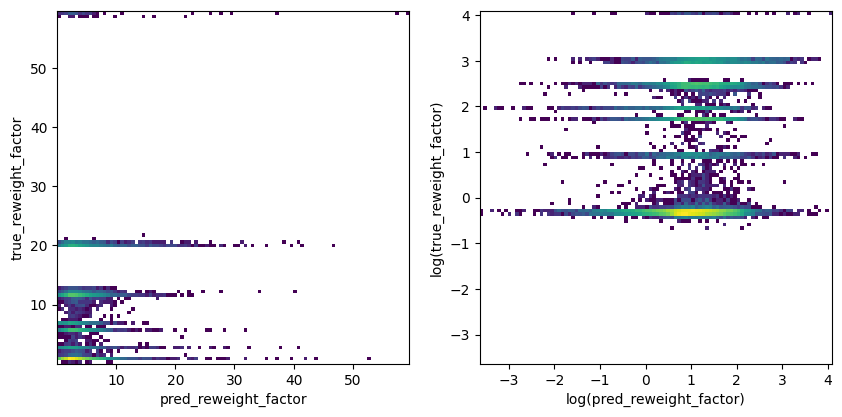

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

lo = min(jnp.min(pred_alt_reweights), jnp.min(true_alt_reweights))
hi = max(jnp.max(pred_alt_reweights), jnp.max(true_alt_reweights))

axes[0].hist2d(pred_alt_reweights, true_alt_reweights, range=((lo, hi), (lo, hi)), bins=100, norm=mpl.colors.LogNorm())
axes[1].hist2d(jnp.log(pred_alt_reweights), jnp.log(true_alt_reweights), range=jnp.log(jnp.array(((lo, hi), (lo, hi)))), bins=100, norm=mpl.colors.LogNorm())

for ax in axes:
    ax.set_aspect('equal')

axes[0].set_xlabel('pred_reweight_factor')
axes[0].set_ylabel('true_reweight_factor')

axes[1].set_xlabel('log(pred_reweight_factor)')
axes[1].set_ylabel('log(true_reweight_factor)')

print(f"{alt_param.tolist() = }")

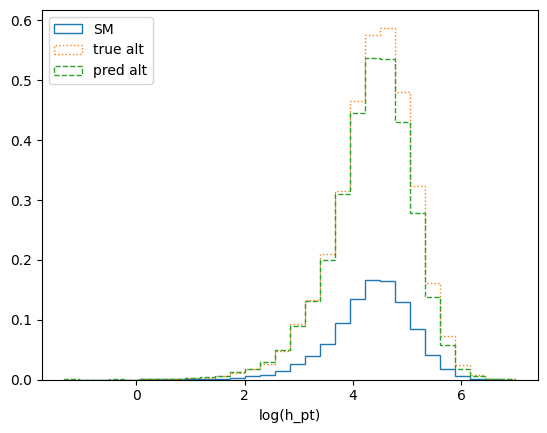

In [35]:
fig, ax = plt.subplots()

log_h_pt = data.observables[:,0]

bins=30
num_events = len(data.observables)

ax.hist(log_h_pt, linestyle='solid', weights=jnp.ones(num_events)/num_events, label="SM", histtype='step', bins=bins)
ax.hist(log_h_pt, linestyle='dotted', weights=true_alt_reweights/num_events, label="true alt", histtype='step', bins=bins)
ax.hist(log_h_pt, linestyle='dashed', weights=pred_alt_reweights/num_events, label="pred alt", histtype='step', bins=bins)

ax.set_xlabel("log(h_pt)")

ax.legend(loc=2)

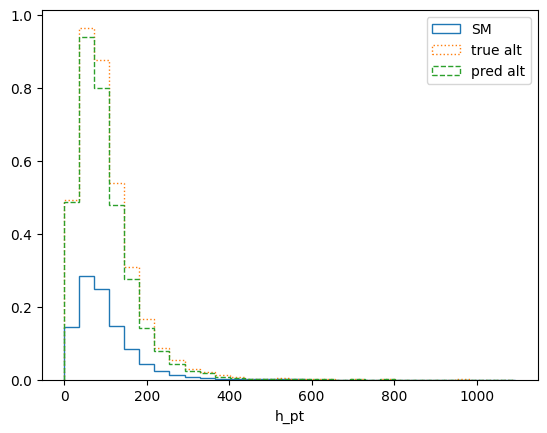

In [36]:
fig, ax = plt.subplots()

h_pt = jnp.exp(data.observables[:,0])

bins=30
num_events = len(data.observables)

ax.hist(h_pt, linestyle='solid', weights=jnp.ones(num_events)/num_events, label="SM", histtype='step', bins=bins)
ax.hist(h_pt, linestyle='dotted', weights=true_alt_reweights/num_events, label="true alt", histtype='step', bins=bins)
ax.hist(h_pt, linestyle='dashed', weights=pred_alt_reweights/num_events, label="pred alt", histtype='step', bins=bins)

ax.set_xlabel("h_pt")

ax.legend(loc=1)

In [37]:
from pathlib import Path
from event2vec.model import PSDMatrixModel_LearnedLLR
from event2vec.prior import SMPlusNormalParameterPrior
from event2vec.analysis import run_analysis
from event2vec.training import MetricsHistory

In [38]:
llr_model = PSDMatrixModel_LearnedLLR(
    psd_matrix_model=trained_psd_matrix_model, 
    normalization=data.normalization,
)

In [39]:
key = jax.random.key(42)
_, *points_keys = jax.random.split(key, 4)

prior = SMPlusNormalParameterPrior(
    mean = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0]),
    cov = jnp.diag(jnp.array([0.5, 2.0, 0.005, 0.00025, 0.003])**2)
)

study_points = {
    "SM": jnp.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
    "rnd0": prior.sample(points_keys[0]),
    "rnd1": prior.sample(points_keys[1]),
    "rnd2": prior.sample(points_keys[2]),
}

In [40]:
run_analysis(
    model=llr_model,
    data=data,
    metrics=MetricsHistory(train_loss=train_loss_history, test_loss=test_loss_history),
    study_points=study_points,
    output_dir=Path("../matrix_regression_analysis_6/")
)

Output()